# Preprocesamiento de Datos Demográficos - Proyecto Monitorización Multimodal de Alzheimer


Este cuaderno se enfoca en el preprocesamiento de los datos demográficos del estudio ADNI, específicamente del archivo PTDEMOG.csv. Los datos demográficos proporcionan información crucial sobre los participantes del estudio, como edad, género, educación, estado civil, etnia, idiomas hablados, entre otros. Estos datos son fundamentales para:
- Caracterizar la población de estudio
- Identificar factores de riesgo demográficos para el Alzheimer
- Estratificar pacientes para análisis específicos
- Controlar sesgos en futuros modelos predictivos

***

## Importación de bibliotecas necesarias

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [128]:
# Configuración de visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Configuración para mostrar más columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Cargar datos

In [129]:
# Definir la ruta de los datos
data_path = "../data/raw/adni/demographics"

# Cargar el archivo de datos demográficos
demographics_df = pd.read_csv(os.path.join(data_path, "PTDEMOG.csv"), low_memory=False)

# Información básica sobre el dataset
print("Dimensiones del dataset:", demographics_df.shape)
print(f"Número de pacientes únicos: {demographics_df['RID'].nunique()}")

Dimensiones del dataset: (5855, 84)
Número de pacientes únicos: 4686


## Inspección inicial de los datos

In [130]:
# Mostrar las primeras filas del dataset
display(demographics_df.head())

# Información de tipos de datos y valores no nulos
demographics_df.info(verbose=True, show_counts=True)

# Resumen estadístico de las variables numéricas
display(demographics_df.describe())

# Recuento de valores para variables categóricas importantes
categorical_vars = ['PTGENDER', '-', 'PTMARRY', 'PTHAND', 'PTETHCAT', 'PTRACCAT']
for var in categorical_vars:
    if var in demographics_df.columns:
        print(f"\nDistribución de {var}:")
        print(demographics_df[var].value_counts(dropna=False))
        print(f"Porcentaje de valores faltantes: {demographics_df[var].isna().mean()*100:.2f}%") 

,PHASE,PTID,RID,VISCODE,VISCODE2,VISDATE,PTSOURCE,PTGENDER,PTDOB,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTWORKHS,PTWORK,PTNOTRT,PTRTYR,PTHOME,PTTLANG,PTPLANG,PTADBEG,PTCOGBEG,PTADDX,PTETHCAT,PTRACCAT,PTIDENT,PTORIENT,PTORIENTOT,PTENGSPK,PTNLANG,PTENGSPKAGE,PTCLANG,PTLANGSP,PTLANGWR,PTSPTIM,PTSPOTTIM,PTLANGPR1,PTLANGSP1,PTLANGRD1,PTLANGWR1,PTLANGUN1,PTLANGPR2,PTLANGSP2,PTLANGRD2,PTLANGWR2,PTLANGUN2,PTLANGPR3,PTLANGSP3,PTLANGRD3,PTLANGWR3,PTLANGUN3,PTLANGPR4,PTLANGSP4,PTLANGRD4,PTLANGWR4,PTLANGUN4,PTLANGPR5,PTLANGSP5,PTLANGRD5,PTLANGWR5,PTLANGUN5,PTLANGPR6,PTLANGSP6,PTLANGRD6,PTLANGWR6,PTLANGUN6,PTLANGTTL,PTETHCATH,PTASIAN,PTOPI,PTBORN,PTBIRPL,PTIMMAGE,PTIMMWHY,PTBIRPR,PTBIRGR,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp
0,ADNI1,011_S_0002,2,sc,sc,2005-08-17,1.0,1.0,04/1931,1931.0,2.0,1.0,16.0,-4.0,NaN,1.0,1989.0,1.0,1.0,1.0,-4.0,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,107,2005-08-17,NaN,NaN,NaN,NaN,2005-08-17 00:00:00.0
1,ADNI1,022_S_0001,1,f,f,2005-08-18,1.0,2.0,12/1944,1944.0,-4.0,1.0,18.0,-4.0,NaN,-4.0,NaN,1.0,-4.0,-4.0,-4.0,NaN,NaN,-4.0,-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,10,2005-08-18,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
2,ADNI1,011_S_0003,3,sc,sc,2005-08-18,1.0,1.0,05/1924,1924.0,1.0,1.0,18.0,-4.0,NaN,1.0,1989.0,3.0,1.0,1.0,1999.0,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,107,2005-08-18,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
3,ADNI1,022_S_0004,4,sc,sc,2005-08-18,1.0,1.0,01/1938,1938.0,1.0,1.0,10.0,-4.0,NaN,0.0,NaN,1.0,2.0,2.0,-4.0,NaN,NaN,1.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,10,2005-08-18,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
4,ADNI1,011_S_0005,5,sc,sc,2005-08-23,1.0,1.0,12/1931,1931.0,1.0,1.0,16.0,-4.0,NaN,1.0,1987.0,1.0,1.0,1.0,-4.0,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,107,2005-08-23,NaN,NaN,NaN,NaN,2005-08-23 00:00:00.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5855 entries, 0 to 5854
Data columns (total 84 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PHASE                 5855 non-null   object 
 1   PTID                  5855 non-null   object 
 2   RID                   5855 non-null   int64  
 3   VISCODE               5855 non-null   object 
 4   VISCODE2              5846 non-null   object 
 5   VISDATE               5848 non-null   object 
 6   PTSOURCE              5848 non-null   float64
 7   PTGENDER              5728 non-null   float64
 8   PTDOB                 5669 non-null   object 
 9   PTDOBYY               5669 non-null   float64
 10  PTHAND                5713 non-null   float64
 11  PTMARRY               5841 non-null   float64
 12  PTEDUCAT              5710 non-null   float64
 13  PTWORKHS              3528 non-null   float64
 14  PTWORK                979 non-null    float64
 15  PTNOTRT              

,RID,PTSOURCE,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTWORKHS,PTWORK,PTNOTRT,PTRTYR,PTHOME,PTTLANG,PTPLANG,PTADBEG,PTCOGBEG,PTADDX,PTETHCAT,PTORIENT,PTORIENTOT,PTENGSPK,PTENGSPKAGE,PTCLANG,PTLANGSP,PTLANGWR,PTSPTIM,PTSPOTTIM,PTLANGPR1,PTLANGSP1,PTLANGRD1,PTLANGWR1,PTLANGUN1,PTLANGPR2,PTLANGSP2,PTLANGRD2,PTLANGWR2,PTLANGUN2,PTLANGPR3,PTLANGSP3,PTLANGRD3,PTLANGWR3,PTLANGUN3,PTLANGPR4,PTLANGSP4,PTLANGRD4,PTLANGWR4,PTLANGUN4,PTLANGPR5,PTLANGSP5,PTLANGRD5,PTLANGWR5,PTLANGUN5,PTLANGPR6,PTLANGSP6,PTLANGRD6,PTLANGWR6,PTLANGUN6,PTLANGTTL,PTOPI,PTBORN,PTBIRPL,PTIMMAGE,PTBIRPR,PTBIRGR,ID,SITEID,HAS_QC_ERROR
count,5855.000000,5848.000000,5728.000000,5669.000000,5713.000000,5841.000000,5710.000000,3528.000000,979.000000,5827.000000,4496.000000,5837.000000,5728.000000,5727.000000,1512.000000,4087.000000,3628.000000,5729.000000,751.000000,4.000000,988.000000,115.000000,988.000000,988.000000,988.000000,988.000000,988.000000,214.000000,203.000000,203.000000,203.000000,203.000000,203.000000,183.000000,183.000000,183.000000,183.000000,183.000000,66.000000,66.000000,66.000000,66.000000,66.000000,34.000000,34.000000,34.000000,34.000000,34.000000,18.000000,18.000000,18.000000,18.000000,18.000000,7.000000,7.000000,7.000000,7.000000,203.000000,2.0,989.000000,151.000000,149.000000,989.000000,989.000000,5855.000000,5855.000000,989.000000
mean,4107.258070,1.011628,1.440468,1940.720233,1.031857,1.513782,15.726795,-1.050454,3.090909,0.779303,2003.119884,2.647764,0.947451,0.991269,495.222884,5250.997309,8922.617971,1.872927,1.993342,6.500000,0.783401,11.469565,1.161943,1.054656,1.032389,96.211538,4.786437,0.948598,6.049261,6.024631,5.857143,6.142857,0.901478,5.464481,5.327869,4.978142,5.568306,0.360656,4.742424,4.606061,4.121212,5.136364,0.515152,3.294118,3.500000,2.823529,3.705882,0.529412,2.944444,3.722222,2.666667,3.444444,0.388889,3.714286,4.142857,3.571429,4.428571,2.596059,3.0,0.848332,6.860927,20.543624,0.784631,0.652174,21349.686763,56.692400,0.006067
std,3140.461097,0.107213,0.738298,11.219346,0.627091,1.006413,3.473590,2.449433,2.062646,0.541162,119.828708,3.024228,0.571908,0.634546,868.019790,3923.222393,2727.518185,0.722674,0.222011,4.123106,0.412136,9.214140,0.501355,0.283001,0.213438,14.231577,16.973784,0.221334,1.559873,1.615024,1.721813,1.490659,0.298756,1.702485,1.861005,2.056767,1.649003,0.481508,1.947864,2.029618,2.222370,1.847130,0.503600,1.337782,1.561856,1.604361,1.467412,0.506640,1.513555,1.775836,1.748949,1.542428,0.501631,2.058663,1.772811,2.225395,1.718249,1.136428,0.0,0.361690,1.939209,14.053221,0.421015,0.517261,36521.790446,103.733505,0.077692
min,1.000000,1.000000,-4.000000,1915.000000,-4.000000,-4.000000,-4.000000,-4.000000,1.000000,-4.000000,1926.000000,-4.000000,-4.000000,-4.000000,-4.000000,1980.000000,1980.000000,-4.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,2.000000,1.000000,2.000000,1.000000,3.0,0.000000,1.000000,0.000000,0.000000,0.000000,12.000000,1.000000,0.000000
25%,1023.000000,1.000000,1.000000,1932.000000,1.000000,1.000000,14.000000,-4.000000,1.000000,1.000000,1994.000000,1.000000,1.000000,1.000000,-4.000000,2008.000000,9999.000000,2.000000,2.000000,3.000000,1.000000,5.000000,1.000000,1.000000,1.000000,100.000000,0.000000,1.000000,6.000000,5.000000,5.000000,6.000000,1.000000,4.000000,4.000000,3.000000,4.000000,0.000000,3.000000,3.000000,2.000000,3.250000,0.000000,2.000000,3.000000,1.250000,3.000000,0.000000,2.000000,3.000000,1.000000,2.250000,0.000000,2.000000,3.000000,2.000000,3.500000,2.000000,3.0,1.000000,5.000000,8.000000,1.000000,0.000000,999.000000,17.000000,0.000000
50%,4392.000000,1.000000,1.000000,1940.000000,1.000000,1.000000,16.000000,1.000000,2.000000,1.000000,2002.000000,1.000000,1.000000,1.000000,-4.000000,2017.000


Distribución de PTGENDER:
PTGENDER
 1.0    2863
 2.0    2808
 NaN     127
-4.0      57
Name: count, dtype: int64
Porcentaje de valores faltantes: 2.17%

Distribución de PTMARRY:
PTMARRY
 1.0    4151
 2.0     678
 3.0     627
 4.0     320
 5.0      26
 6.0      20
-4.0      19
 NaN      14
Name: count, dtype: int64
Porcentaje de valores faltantes: 0.24%

Distribución de PTHAND:
PTHAND
 1.0    5117
 2.0     527
 NaN     142
-4.0      69
Name: count, dtype: int64
Porcentaje de valores faltantes: 2.43%

Distribución de PTETHCAT:
PTETHCAT
 2.0    5305
 1.0     310
 NaN     126
-4.0      76
 3.0      38
Name: count, dtype: int64
Porcentaje de valores faltantes: 2.15%

Distribución de PTRACCAT:
PTRACCAT
5        4717
4         630
2         162
NaN       127
-4         74
6          51
7          49
1          10
1|5         7
2|5         6
4|5         5
1|4         4
3           4
2|4         3
9           2
3|4|5       1
1|7         1
1|4|5       1
5|7         1
Name: count, dtype: int64
P

## Análisis de valores faltantes

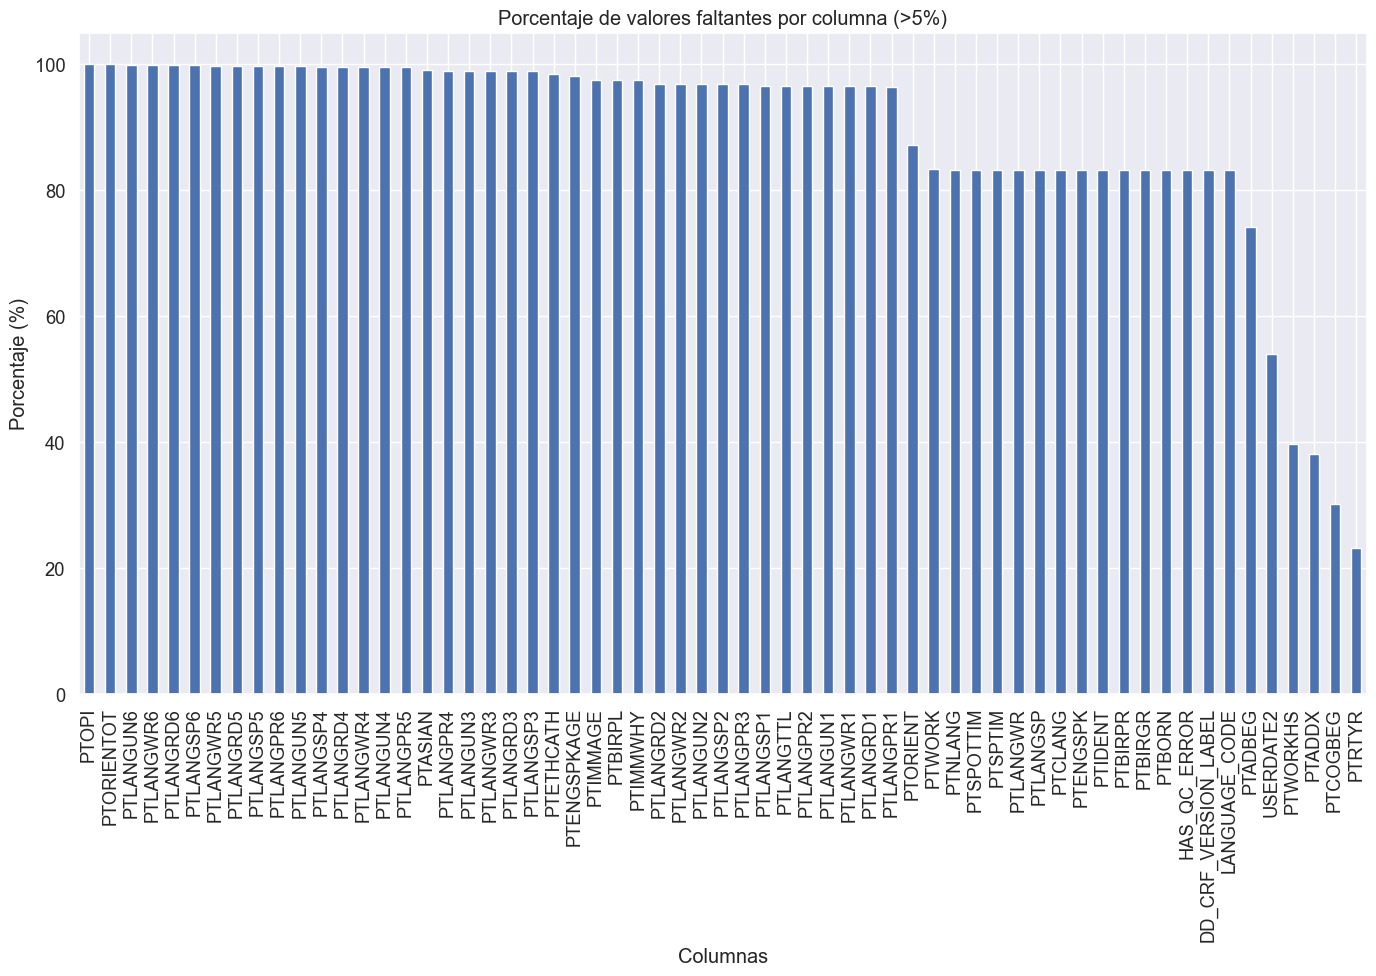

Columnas con más del 50% de valores faltantes (57):
['PTOPI', 'PTORIENTOT', 'PTLANGUN6', 'PTLANGWR6', 'PTLANGRD6', 'PTLANGSP6', 'PTLANGWR5', 'PTLANGRD5', 'PTLANGSP5', 'PTLANGPR6', 'PTLANGUN5', 'PTLANGSP4', 'PTLANGRD4', 'PTLANGWR4', 'PTLANGUN4', 'PTLANGPR5', 'PTASIAN', 'PTLANGPR4', 'PTLANGUN3', 'PTLANGWR3', 'PTLANGRD3', 'PTLANGSP3', 'PTETHCATH', 'PTENGSPKAGE', 'PTIMMAGE', 'PTBIRPL', 'PTIMMWHY', 'PTLANGRD2', 'PTLANGWR2', 'PTLANGUN2', 'PTLANGSP2', 'PTLANGPR3', 'PTLANGSP1', 'PTLANGTTL', 'PTLANGPR2', 'PTLANGUN1', 'PTLANGWR1', 'PTLANGRD1', 'PTLANGPR1', 'PTORIENT', 'PTWORK', 'PTNLANG', 'PTSPOTTIM', 'PTSPTIM', 'PTLANGWR', 'PTLANGSP', 'PTCLANG', 'PTENGSPK', 'PTIDENT', 'PTBIRPR', 'PTBIRGR', 'PTBORN', 'HAS_QC_ERROR', 'DD_CRF_VERSION_LABEL', 'LANGUAGE_CODE', 'PTADBEG', 'USERDATE2']


In [131]:
# Calcular el porcentaje de valores faltantes por columna
missing_values = demographics_df.isnull().mean().sort_values(ascending=False) * 100

# Visualizar las columnas con más valores faltantes
plt.figure(figsize=(14, 10))
missing_values[missing_values > 5].plot(kind='bar')
plt.title('Porcentaje de valores faltantes por columna (>5%)')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Columnas')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Columnas con alto porcentaje de valores faltantes
high_missing = missing_values[missing_values > 50].index.tolist()
print(f"Columnas con más del 50% de valores faltantes ({len(high_missing)}):")
print(high_missing)

## Preprocesamiento de variables demográficas clave

In [132]:
def preprocess_demographics(df):
    """
    Función para preprocesar datos demográficos:
    - Convirtiendo IDs a string
    - Parseo de fechas PTPDOB (MM-YYYY) y VISDATE (YYYY-MM-DD)
    - Cálculo de AGE a partir de fechas o año de nacimiento
    - Limpieza de años de inicio de síntomas (PTADBEG, PTCOGBEG)
    - Estandarización de género, educación, estado civil, etnia, raza, dominancia y bilingüismo
    - Creación de variables dummy
    - Eliminación de columnas con >50% valores faltantes
    """
    # Crear una copia para no modificar el original
    processed_df = df.copy()
    
    # Convertir identificadores a tipo string
    id_cols = ['RID', 'PTID']
    for col in id_cols:
        if col in processed_df.columns:
            processed_df[col] = processed_df[col].astype(str)
    
    # Parseo de fechas:
    # PTPDOB: formato 'MM-YYYY' -> asumimos día 1
    if 'PTDOB' in processed_df.columns:
        processed_df['PTDOB'] = pd.to_datetime(
            processed_df['PTDOB'], format='%m-%Y', errors='coerce'
        )
    # VISDATE: formato 'YYYY-MM-DD'
    if 'VISDATE' in processed_df.columns:
        processed_df['VISDATE'] = pd.to_datetime(
            processed_df['VISDATE'], format='%Y-%m-%d', errors='coerce'
        )
    # PTPDOBBY (año): convertir a int
    if 'PTDOBYY' in processed_df.columns:
        processed_df['PTDOBYY'] = pd.to_numeric(
            processed_df['PTDOBYY'], errors='coerce'
        ).astype('Int64')

    # Cálculo de edad
    # Prioriza fecha completa si disponible
    if 'VISDATE' in processed_df.columns and 'PTDOB' in processed_df.columns:
        mask_full = processed_df['PTDOB'].notna() & processed_df['VISDATE'].notna()
        processed_df.loc[mask_full, 'AGE'] = (
            (processed_df.loc[mask_full, 'VISDATE'] - processed_df.loc[mask_full, 'PTDOB']).dt.days / 365.25
        ).round(1)
        # Para quienes no tienen fecha completa, usar año
        mask_year = processed_df['AGE'].isna() & processed_df['VISDATE'].notna() & processed_df['PTDOBYY'].notna()
        processed_df.loc[mask_year, 'AGE'] = (
            processed_df.loc[mask_year, 'VISDATE'].dt.year - processed_df.loc[mask_year, 'PTDOBYY']
        )
    # Filtrar edades razonables (50-110)
    processed_df.loc[~processed_df['AGE'].between(50, 110), 'AGE'] = np.nan

    # Síntomas Alzheimer
    # Año inicio síntomas Alzheimer (PTADBEG)
    if 'PTADBEG' in processed_df.columns:
        processed_df['PTADBEG'] = pd.to_numeric(
            processed_df['PTADBEG'], errors='coerce'
        ).astype('Int64')
        processed_df.loc[processed_df['PTADBEG'] == 9999, 'PTADBEG'] = pd.NA

    # Año inicio síntomas cognitivos (PTCOGBEG)
    if 'PTCOGBEG' in processed_df.columns:
        processed_df['PTCOGBEG'] = pd.to_numeric(
            processed_df['PTCOGBEG'], errors='coerce'
        ).astype('Int64')
        processed_df.loc[processed_df['PTCOGBEG'] == 9999, 'PTCOGBEG'] = pd.NA
    
    # Resto del Preprocesamiento (género, educación, estado civil, etc.)
    # Preprocesamiento de género numérico
    if 'PTGENDER' in processed_df.columns:
        # Mapear códigos numéricos: 1->Male, 2->Female, otros/(-4)->NaN
        gender_map = {1: 'Male', 2: 'Female', -4: np.nan}
        processed_df['PTGENDER'] = pd.to_numeric(processed_df['PTGENDER'], errors='coerce').map(gender_map)
        # Dummy: 1 si Male, 0 si Female o NaN
        processed_df['GENDER_MALE'] = (processed_df['PTGENDER'] == 'Male').astype(int)
    
    # Preprocesamiento de nivel educativo (PTEDUCAT)
    if 'PTEDUCAT' in processed_df.columns:
        # Convertir a numérico si no lo es
        processed_df['PTEDUCAT'] = pd.to_numeric(processed_df['PTEDUCAT'], errors='coerce')
        
        # Verificar valores razonables (entre 0 y 30 años de educación)
        #processed_df.loc[(processed_df['PTEDUCAT'] < 0) | (processed_df['PTEDUCAT'] > 30), 'PTEDUCAT'] = np.nan
        processed_df.loc[~processed_df['PTEDUCAT'].between(0, 30), 'PTEDUCAT'] = np.nan
        
        # Crear categorías de nivel educativo
        bins = [0, 12, 16, 30]
        labels = ['Básica', 'Media', 'Superior']
        processed_df['EDUCATION_LEVEL'] = pd.cut(processed_df['PTEDUCAT'], bins=bins, labels=labels)
    
    # Estado civil numérico
    if 'PTMARRY' in processed_df.columns:
        # Mapear códigos: 1=Married, 2=Widowed, 3=Divorced/Separated,
        # 4=Divorced/Separated, 5=Never married, 6/ -4/otros=NaN
        marry_map = {1:'Married', 2:'Widowed', 3:'Divorced/Separated', 4:'Never married', 5:'Unknown', -4:np.nan, 6:np.nan}
        processed_df['MARITAL_STATUS'] = pd.to_numeric(
            processed_df['PTMARRY'], errors='coerce'
        ).map(marry_map)
        # Crear dummies para análisis posterior
        marital_dummies = pd.get_dummies(
            processed_df['MARITAL_STATUS'], prefix='MARITAL', dummy_na=False
        )
        processed_df = pd.concat([processed_df, marital_dummies], axis=1)
    
    # Preprocesamiento de etnia (PTETHCAT) y raza (PTRACCAT)
    # Etnia (PTETHCAT: [2,-4,1,3,NaN])
    if 'PTETHCAT' in processed_df.columns:
        # 1=Hispanic/Latino, 2=Not Hispanic/not latino, 3=Other
        eth_map = {1:1, 2:0, 3:0, -4:np.nan}
        processed_df['IS_HISPANIC'] = pd.to_numeric(processed_df['PTETHCAT'], errors='coerce').map(eth_map)
    
    # Raza (PTRACCAT: ['5','-4','6','4','2','7','1',NaN,'3','...|...'])
    if 'PTRACCAT' in processed_df.columns:
        def map_race(x):
            if pd.isna(x):
                return np.nan
            codes = str(x).split('|')
            # 1=Native American/Alaskan Native
            if '1' in codes:
                return 'Native American'
            # 2=Asian
            if '2' in codes:
                return 'Asian'
            # 3=Pacific Islander
            if '3' in codes:
                return 'Pacific Islander'
            # 4=Black/African American
            if '4' in codes:
                return 'Black'
            # 5=White
            if '5' in codes:
                return 'White'
            # 6=Multiple races
            if '6' in codes:
                return 'Multiple'
            # 7=Unknown
            if '7' in codes:
                return np.nan
            return 'Other'
        processed_df['RACE_GROUP'] = processed_df['PTRACCAT'].apply(map_race)
        dummies = pd.get_dummies(processed_df['RACE_GROUP'], prefix='RACE', dummy_na=False)
        processed_df = pd.concat([processed_df, dummies], axis=1)
    
    # Preprocesamiento de dominancia manual (PTHAND)
    if 'PTHAND' in processed_df.columns:
        hand_map = {1:'Right', 2:'Left', -4:np.nan}
        processed_df['HAND_DOM'] = pd.to_numeric(processed_df['PTHAND'], errors='coerce').map(hand_map)
        processed_df['IS_RIGHT_HANDED'] = (processed_df['HAND_DOM']=='Right').astype(int)
    
    # Preprocesamiento de datos de idioma y bilingüismo
    if 'PTLANGTTL' in processed_df.columns:
        processed_df['PTLANGTTL'] = pd.to_numeric(processed_df['PTLANGTTL'], errors='coerce')
        processed_df['IS_BILINGUAL'] = (processed_df['PTLANGTTL']>1).astype(int)
    
    # Eliminar columnas con alta proporción de valores faltantes
    high_missing_cols = processed_df.columns[processed_df.isnull().mean() > 0.5].tolist()
    #display(print(f"high_missing_cols========> {high_missing_cols}"))
    processed_df.drop(high_missing_cols, axis=1, inplace=True)
    
    return processed_df

# Aplicar el preprocesamiento
demographics_processed = preprocess_demographics(demographics_df)
print("Dataset después del preprocesamiento:")
display(demographics_processed.tail())
#display(demographics_processed.columns)

Dataset después del preprocesamiento:


,PHASE,PTID,RID,VISCODE,VISCODE2,VISDATE,PTSOURCE,PTGENDER,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTWORKHS,PTNOTRT,PTRTYR,PTHOME,PTTLANG,PTPLANG,PTADDX,PTETHCAT,PTRACCAT,ID,SITEID,USERDATE,update_stamp,AGE,GENDER_MALE,EDUCATION_LEVEL,MARITAL_STATUS,MARITAL_Divorced/Separated,MARITAL_Married,MARITAL_Never married,MARITAL_Unknown,MARITAL_Widowed,IS_HISPANIC,RACE_GROUP,RACE_Asian,RACE_Black,RACE_Multiple,RACE_Native American,RACE_Other,RACE_Pacific Islander,RACE_White,HAND_DOM,IS_RIGHT_HANDED,IS_BILINGUAL
5850,ADNI4,003_S_10622,10622,4_sc,sc,2025-03-26,1.0,Female,1968,1.0,3.0,20.0,1.0,0.0,NaN,10.0,1.0,1.0,9999.0,1.0,5,78315,3,2025-03-27,2025-03-28 01:41:01.0,57.0,0,Superior,Divorced/Separated,True,False,False,False,False,1.0,White,False,False,False,False,False,False,True,Right,1,1
5851,ADNI4,126_S_7060,7060,4_init,m36,2025-03-25,1.0,Male,1945,1.0,1.0,15.0,1.0,1.0,2012.0,2.0,1.0,1.0,9999.0,2.0,5,78330,126,2025-03-27,2025-03-28 01:41:01.0,80.0,1,Media,Married,False,True,False,False,False,0.0,White,False,False,False,False,False,False,True,Right,1,0
5852,ADNI4,037_S_10611,10611,4_sc,sc,2025-03-19,1.0,Male,1959,1.0,3.0,14.0,1.0,1.0,2022.0,8.0,1.0,1.0,9999.0,2.0,4,78379,37,2025-03-27,2025-03-28 01:41:01.0,66.0,1,Media,Divorced/Separated,True,False,False,False,False,0.0,Black,False,True,False,False,False,False,False,Right,1,0
5853,ADNI4,067_S_10605,10605,4_sc,sc,2025-03-12,1.0,Male,1960,1.0,3.0,13.0,1.0,1.0,2018.0,3.0,1.0,1.0,9999.0,2.0,4,78568,67,2025-03-27,2025-03-28 01:41:01.0,65.0,1,Media,Divorced/Separated,True,False,False,False,False,0.0,Black,False,True,False,False,False,False,False,Right,1,0
5854,ADNI4,153_S_10407,10407,4_sc,sc,2025-03-27,1.0,Female,1959,1.0,3.0,16.0,1.0,0.0,NaN,3.0,1.0,1.0,9999.0,2.0,4,78575,153,2025-03-27,2025-03-28 01:41:01.0,66.0,0,Media,Divorced/Separated,True,False,False,False,False,0.0,Black,False,True,False,False,False,False,False,Right,1,0


## Análisis de datos preprocesados

,VISDATE,PTSOURCE,PTDOBYY,PTHAND,PTMARRY,PTEDUCAT,PTWORKHS,PTNOTRT,PTRTYR,PTHOME,PTTLANG,PTPLANG,PTADDX,PTETHCAT,ID,SITEID,AGE,GENDER_MALE,IS_HISPANIC,IS_RIGHT_HANDED,IS_BILINGUAL
count,5848,5848.000000,5669.0,5713.000000,5841.000000,5649.000000,3528.000000,5827.000000,4496.000000,5837.000000,5728.000000,5727.000000,3628.000000,5729.000000,5855.000000,5855.000000,5667.000000,5855.000000,5653.000000,5855.000000,5855.000000
mean,2014-02-21 14:46:12.640219136,1.011628,1940.720233,1.031857,1.513782,15.937688,-1.050454,0.779303,2003.119884,2.647764,0.947451,0.991269,8922.617971,1.872927,21349.686763,56.692400,73.063349,0.488984,0.054838,0.873954,0.032963
min,2005-08-17 00:00:00,1.000000,1915.0,-4.000000,-4.000000,3.000000,-4.000000,-4.000000,1926.000000,-4.000000,-4.000000,-4.000000,1980.000000,-4.000000,12.000000,1.000000,50.000000,0.000000,0.000000,0.000000,0.000000
25%,2010-06-24 00:00:00,1.000000,1932.0,1.000000,1.000000,14.000000,-4.000000,1.000000,1994.000000,1.000000,1.000000,1.000000,9999.000000,2.000000,999.000000,17.000000,67.000000,0.000000,0.000000,1.000000,0.000000
50%,2012-03-05 00:00:00,1.000000,1940.0,1.000000,1.000000,16.000000,1.000000,1.000000,2002.000000,1.000000,1.000000,1.000000,9999.000000,2.000000,2268.000000,34.000000,73.000000,0.000000,0.000000,1.000000,0.000000
75%,2018-11-30 00:00:00,1.000000,1949.0,1.000000,2.000000,18.000000,1.000000,1.000000,2009.000000,3.000000,1.000000,1.000000,9999.000000,2.000000,30729.000000,55.000000,79.000000,1.000000,0.000000,1.000000,0.000000
max,2025-03-27 00:00:00,2.000000,2025.0,2.000000,6.000000,20.000000,1.000000,2.000000,9999.000000,10.000000,2.000000,3.000000,9999.000000,3.000000,186128.000000,941.000000,104.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,0.107213,11.219346,0.627091,1.006413,2.833058,2.449433,0.541162,119.828708,3.024228,0.571908,0.634546,2727.518185,0.722674,36521.790446,103.733505,8.116956,0.499921,0.227684,0.331930,0.178556


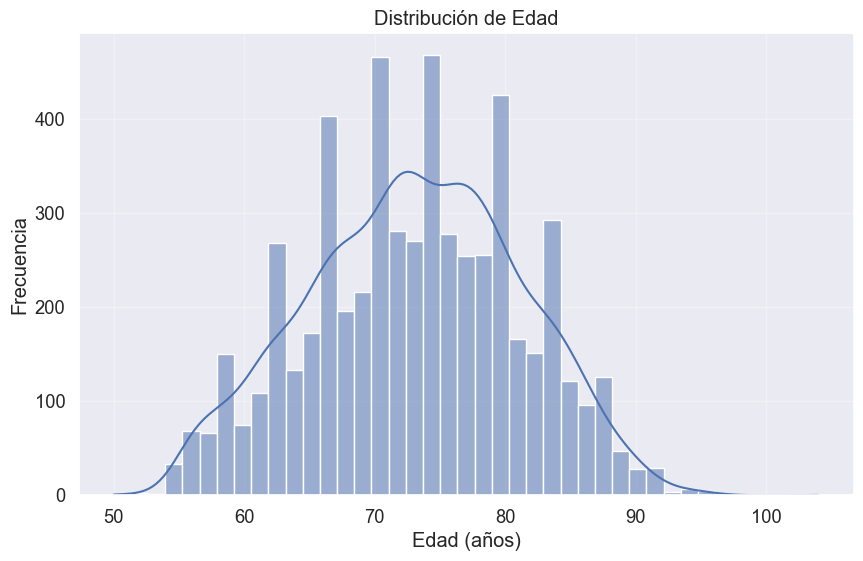

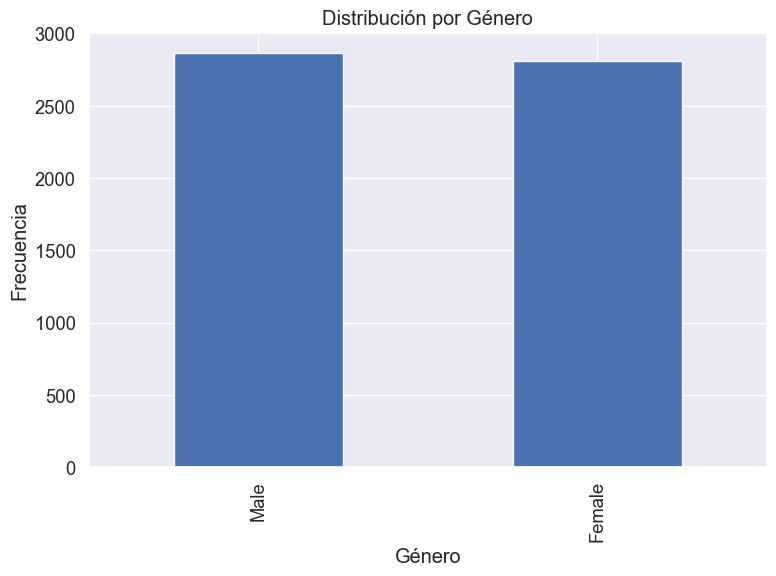

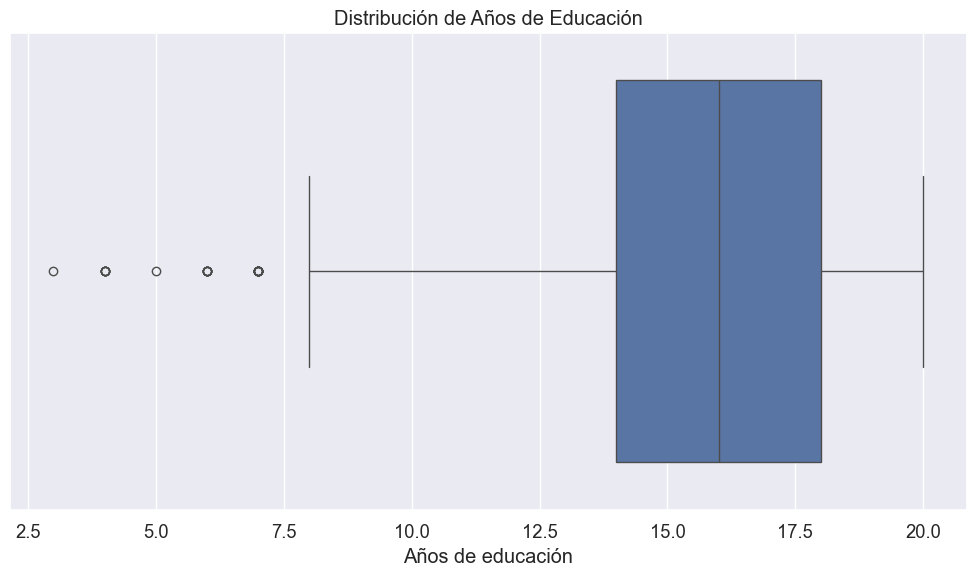

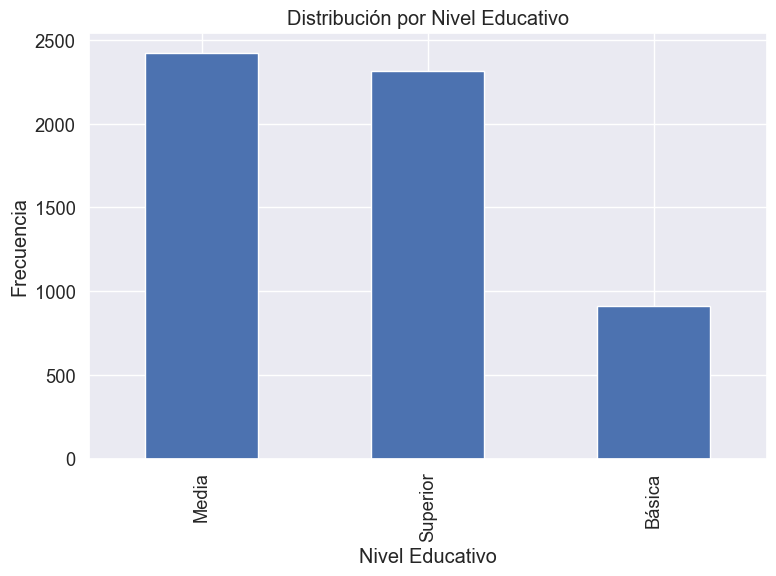

In [133]:
# Resumen estadístico después del preprocesamiento
display(demographics_processed.describe())

# Verificar variables demográficas clave
key_vars = ['RID', 'AGE', 'PTADBEG', 'GENDER_MALE', 'PTEDUCAT', 'MARITAL_STATUS', 'RACE_GROUP', 'IS_BILINGUAL']
if all(var in demographics_processed.columns for var in key_vars):
    print("Resumen de variables demográficas clave:")
    display(demographics_processed[key_vars].head(10))

# Visualizar distribución de edad
if 'AGE' in demographics_processed.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(demographics_processed['AGE'].dropna(), kde=True)
    plt.title('Distribución de Edad')
    plt.xlabel('Edad (años)')
    plt.ylabel('Frecuencia')
    plt.grid(True, alpha=0.3)
    plt.show()

if 'PTADBEG' in demographics_processed.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(demographics_processed['PTADBEG'].dropna(), kde=True)
    plt.title('Distribución de Edad de Inicio del ALzheimer')
    plt.xlabel('Edad (años)')
    plt.ylabel('Frecuencia')
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualizar distribución por género
if 'PTGENDER' in demographics_processed.columns:
    plt.figure(figsize=(8, 6))
    gender_counts = demographics_processed['PTGENDER'].value_counts()
    gender_counts.plot(kind='bar')
    plt.title('Distribución por Género')
    plt.xlabel('Género')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

# Visualizar nivel educativo
if 'PTEDUCAT' in demographics_processed.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=demographics_processed['PTEDUCAT'].dropna())
    plt.title('Distribución de Años de Educación')
    plt.xlabel('Años de educación')
    plt.tight_layout()
    plt.show()

    if 'EDUCATION_LEVEL' in demographics_processed.columns:
        plt.figure(figsize=(8, 6))
        education_counts = demographics_processed['EDUCATION_LEVEL'].value_counts()
        education_counts.plot(kind='bar')
        plt.title('Distribución por Nivel Educativo')
        plt.xlabel('Nivel Educativo')
        plt.ylabel('Frecuencia')
        plt.tight_layout()
        plt.show()

## Análisis de relaciones entre variables demográficas

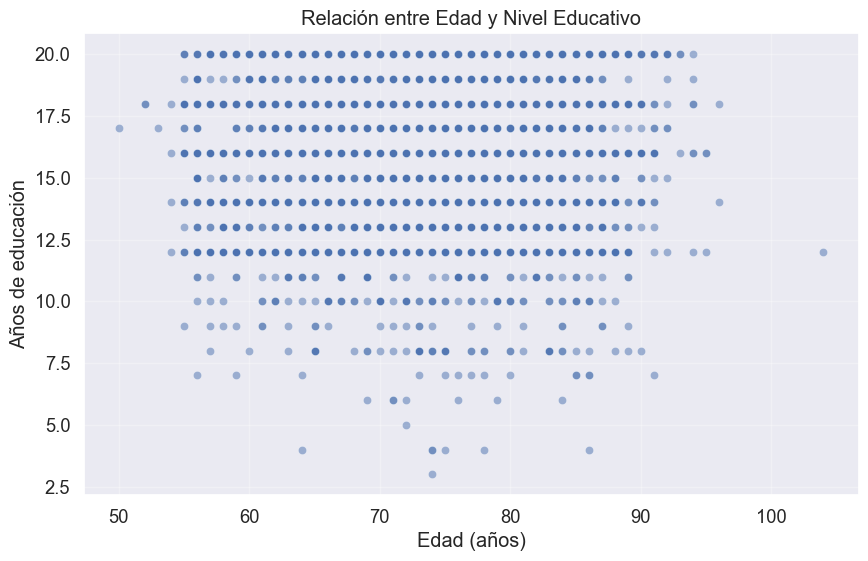

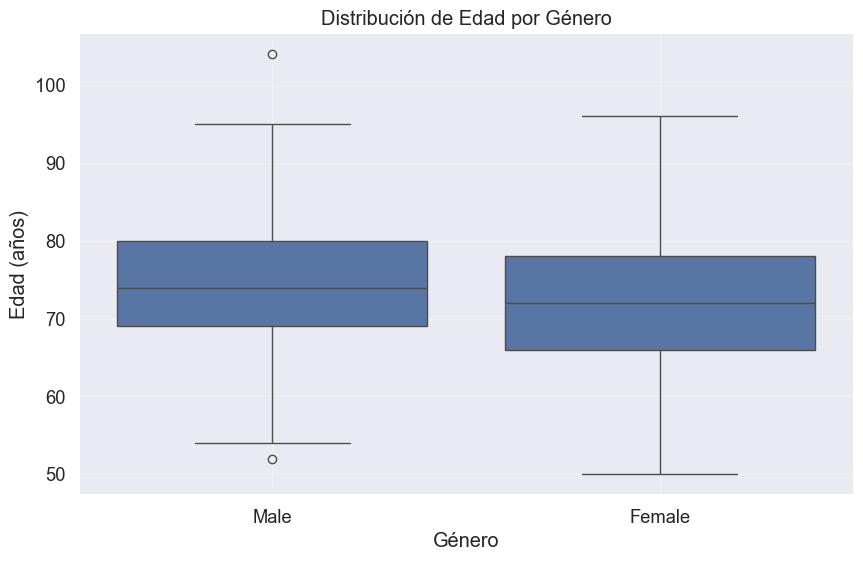

T-test para diferencia de edad entre géneros: t=10.932, p=0.0000


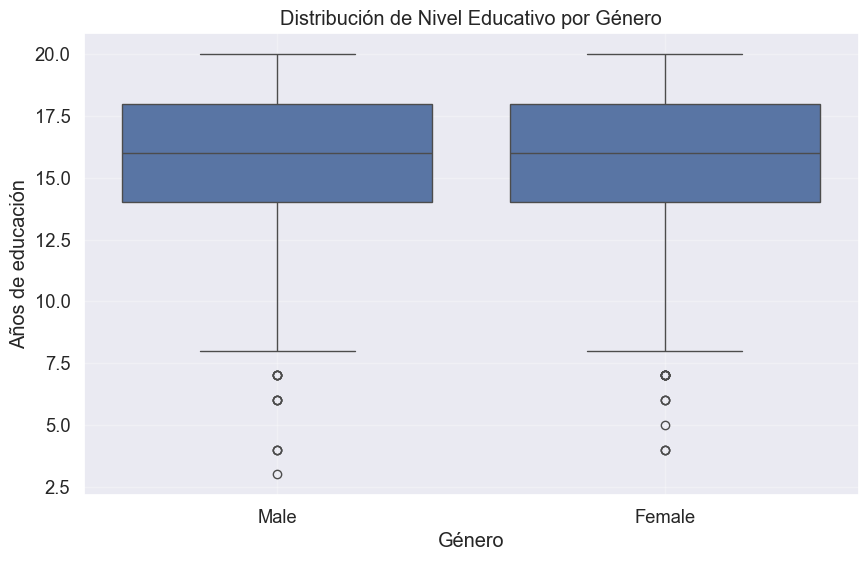

T-test para diferencia de educación entre géneros: t=10.288, p=0.0000


<Figure size 1200x800 with 0 Axes>

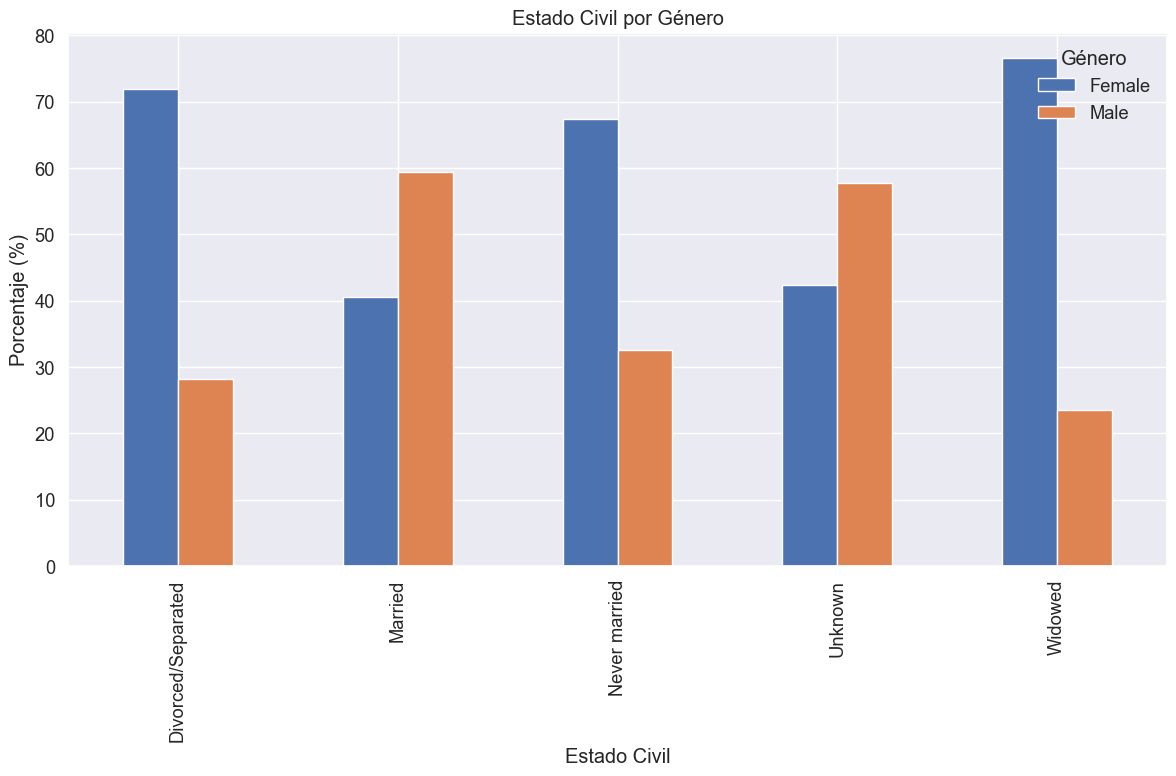

In [134]:
# Relación entre edad y educación
if 'AGE' in demographics_processed.columns and 'PTEDUCAT' in demographics_processed.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=demographics_processed, x='AGE', y='PTEDUCAT', alpha=0.5)
    plt.title('Relación entre Edad y Nivel Educativo')
    plt.xlabel('Edad (años)')
    plt.ylabel('Años de educación')
    plt.grid(True, alpha=0.3)
    plt.show()

# Distribución de edad por género
if 'AGE' in demographics_processed.columns and 'PTGENDER' in demographics_processed.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=demographics_processed, x='PTGENDER', y='AGE')
    plt.title('Distribución de Edad por Género')
    plt.xlabel('Género')
    plt.ylabel('Edad (años)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Comprobación estadística de diferencias
    from scipy import stats
    male_age = demographics_processed[demographics_processed['PTGENDER'] == 'Male']['AGE'].dropna()
    female_age = demographics_processed[demographics_processed['PTGENDER'] == 'Female']['AGE'].dropna()
    
    if len(male_age) > 0 and len(female_age) > 0:
        t_stat, p_value = stats.ttest_ind(male_age, female_age, equal_var=False)
        print(f"T-test para diferencia de edad entre géneros: t={t_stat:.3f}, p={p_value:.4f}")

# Distribución de nivel educativo por género
if 'PTEDUCAT' in demographics_processed.columns and 'PTGENDER' in demographics_processed.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=demographics_processed, x='PTGENDER', y='PTEDUCAT')
    plt.title('Distribución de Nivel Educativo por Género')
    plt.xlabel('Género')
    plt.ylabel('Años de educación')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Comprobación estadística de diferencias
    male_edu = demographics_processed[demographics_processed['PTGENDER'] == 'Male']['PTEDUCAT'].dropna()
    female_edu = demographics_processed[demographics_processed['PTGENDER'] == 'Female']['PTEDUCAT'].dropna()
    
    if len(male_edu) > 0 and len(female_edu) > 0:
        t_stat, p_value = stats.ttest_ind(male_edu, female_edu, equal_var=False)
        print(f"T-test para diferencia de educación entre géneros: t={t_stat:.3f}, p={p_value:.4f}")

# Distribución de estado civil por género
if 'MARITAL_STATUS' in demographics_processed.columns and 'PTGENDER' in demographics_processed.columns:
    plt.figure(figsize=(12, 8))
    marital_gender = pd.crosstab(demographics_processed['MARITAL_STATUS'], 
                                demographics_processed['PTGENDER'], 
                                normalize='index') * 100
    marital_gender.plot(kind='bar', stacked=False)
    plt.title('Estado Civil por Género')
    plt.xlabel('Estado Civil')
    plt.ylabel('Porcentaje (%)')
    plt.legend(title='Género')
    plt.tight_layout()
    plt.show()

## Selección de variables demográficas relevantes para análisis futuro

In [135]:
def select_demographic_features(df):
    """
    Seleccionar variables demográficas más relevantes para análisis posteriores
    """
    # Variables principales a mantener
    main_vars = [
        'RID',           # Identificador de paciente
        'PTID',          # Identificador adicional si existe
        'VISCODE',       # Código de visita
        'VISCODE2',      # Código de visita alternativo
        'VISDATE',       # Fecha de visita
        'AGE',           # Edad calculada
        'PTGENDER',      # Género original
        'GENDER_MALE',   # Variable binaria de género
        'PTEDUCAT',      # Años de educación
        'EDUCATION_LEVEL', # Nivel educativo categorizado
        'MARITAL_STATUS',  # Estado civil recodificado
        'RACE_GROUP',      # Grupo racial recodificado
        'IS_BILINGUAL'     # Indicador de bilingüismo
    ]
    
    # Añadir variables dummy creadas
    dummy_cols = [col for col in df.columns if col.startswith(('MARITAL_', 'RACE_'))]
    main_vars.extend(dummy_cols)
    
    # Filtrar solo columnas que existen en el dataframe
    final_cols = [col for col in main_vars if col in df.columns]
    
    # Seleccionar el subconjunto de variables
    selected_df = df[final_cols].copy()
    
    return selected_df

# Aplicar selección de características
demographics_selected = select_demographic_features(demographics_processed)
print("Variables demográficas seleccionadas:")
print(demographics_selected.columns.tolist())
display(demographics_selected.head())

Variables demográficas seleccionadas:
['RID', 'PTID', 'VISCODE', 'VISCODE2', 'VISDATE', 'AGE', 'PTGENDER', 'GENDER_MALE', 'PTEDUCAT', 'EDUCATION_LEVEL', 'MARITAL_STATUS', 'RACE_GROUP', 'IS_BILINGUAL', 'MARITAL_STATUS', 'MARITAL_Divorced/Separated', 'MARITAL_Married', 'MARITAL_Never married', 'MARITAL_Unknown', 'MARITAL_Widowed', 'RACE_GROUP', 'RACE_Asian', 'RACE_Black', 'RACE_Multiple', 'RACE_Native American', 'RACE_Other', 'RACE_Pacific Islander', 'RACE_White']


,RID,PTID,VISCODE,VISCODE2,VISDATE,AGE,PTGENDER,GENDER_MALE,PTEDUCAT,EDUCATION_LEVEL,MARITAL_STATUS,RACE_GROUP,IS_BILINGUAL,MARITAL_STATUS,MARITAL_Divorced/Separated,MARITAL_Married,MARITAL_Never married,MARITAL_Unknown,MARITAL_Widowed,RACE_GROUP,RACE_Asian,RACE_Black,RACE_Multiple,RACE_Native American,RACE_Other,RACE_Pacific Islander,RACE_White
0,2,011_S_0002,sc,sc,2005-08-17,74.0,Male,1,16.0,Media,Married,White,0,Married,False,True,False,False,False,White,False,False,False,False,False,False,True
1,1,022_S_0001,f,f,2005-08-18,61.0,Female,0,18.0,Superior,Married,Other,0,Married,False,True,False,False,False,Other,False,False,False,False,True,False,False
2,3,011_S_0003,sc,sc,2005-08-18,81.0,Male,1,18.0,Superior,Married,White,0,Married,False,True,False,False,False,White,False,False,False,False,False,False,True
3,4,022_S_0004,sc,sc,2005-08-18,67.0,Male,1,10.0,Básica,Married,White,0,Married,False,True,False,False,False,White,False,False,False,False,False,False,True
4,5,011_S_0005,sc,sc,2005-08-23,74.0,Male,1,16.0,Media,Married,White,0,Married,False,True,False,False,False,White,False,False,False,False,False,False,True


## Eliminar duplicados y obtener datos demográficos más recientes por paciente

In [136]:
def get_latest_demographics(df):
    """
    Obtener los datos demográficos más recientes para cada paciente
    """
    # Verificar si hay múltiples registros por paciente
    records_per_patient = df.groupby('RID').size()
    print(f"Promedio de registros por paciente: {records_per_patient.mean():.2f}")
    print(f"Máximo de registros por paciente: {records_per_patient.max()}")
    
    # Si hay fecha de visita, usar el registro más reciente
    if 'VISDATE' in df.columns:
        # Ordenar por RID y fecha de visita (descendente)
        df_sorted = df.sort_values(['RID', 'VISDATE'], ascending=[True, False])
        
        # Tomar el primer registro (más reciente) para cada paciente
        latest_df = df_sorted.groupby('RID').first().reset_index()
        
        print(f"Registros originales: {len(df)}")
        print(f"Pacientes únicos con datos más recientes: {len(latest_df)}")
        
        return latest_df
    else:
        # Si no hay fecha, eliminar duplicados manteniendo el primero
        unique_df = df.drop_duplicates(subset=['RID'], keep='first')
        
        print(f"Registros originales: {len(df)}")
        print(f"Pacientes únicos después de eliminar duplicados: {len(unique_df)}")
        
        return unique_df

# Obtener datos demográficos más recientes por paciente
latest_demographics = get_latest_demographics(demographics_selected)
display(latest_demographics.head())

Promedio de registros por paciente: 1.25
Máximo de registros por paciente: 6
Registros originales: 5855
Pacientes únicos con datos más recientes: 4686


,RID,PTID,VISCODE,VISCODE2,VISDATE,AGE,PTGENDER,GENDER_MALE,PTEDUCAT,EDUCATION_LEVEL,MARITAL_STATUS,RACE_GROUP,IS_BILINGUAL,MARITAL_STATUS,MARITAL_Divorced/Separated,MARITAL_Married,MARITAL_Never married,MARITAL_Unknown,MARITAL_Widowed,RACE_GROUP,RACE_Asian,RACE_Black,RACE_Multiple,RACE_Native American,RACE_Other,RACE_Pacific Islander,RACE_White
0,1,022_S_0001,f,f,2005-08-18,61.0,Female,0,18.0,Superior,Married,Other,0,Married,False,True,False,False,False,Other,False,False,False,False,True,False,False
1,10,011_S_0010,sc,sc,2005-10-26,74.0,Female,0,12.0,Básica,Married,White,0,Married,False,True,False,False,False,White,False,False,False,False,False,False,True
2,100,068_S_0100,f,f,2005-12-12,75.0,Female,0,14.0,Media,Married,White,0,Married,False,True,False,False,False,White,False,False,False,False,False,False,True
3,1000,099_S_1000,f,f,2006-10-11,82.0,Male,1,12.0,Básica,Divorced/Separated,White,0,Divorced/Separated,True,False,False,False,False,White,False,False,False,False,False,False,True
4,10001,941_S_10001,4_sc,sc,2023-07-25,82.0,Female,0,14.0,Media,Married,White,0,Married,False,True,False,False,False,White,False,False,False,False,False,False,True


### Identificar y eliminar columnas duplicadas

In [137]:
print("Columnas duplicadas en latest_demographics:", latest_demographics.columns[latest_demographics.columns.duplicated()].tolist())
print("Columnas duplicadas en demographics_selected:", demographics_selected.columns[demographics_selected.columns.duplicated()].tolist())

Columnas duplicadas en latest_demographics: ['MARITAL_STATUS', 'RACE_GROUP']
Columnas duplicadas en demographics_selected: ['MARITAL_STATUS', 'RACE_GROUP']


In [138]:
latest_demographics = latest_demographics.loc[:, ~latest_demographics.columns.duplicated(keep='first')]
demographics_selected = demographics_selected.loc[:, ~demographics_selected.columns.duplicated(keep='first')]

## Guardar datos procesados

In [139]:
# Definir la ruta para guardar los datos procesados
processed_path = "../data/processed/demographics/"

# Crear el directorio si no existe
os.makedirs(processed_path, exist_ok=True)

# Guardar los datasets procesados
demographics_processed.to_csv(os.path.join(processed_path, "demographics_processed_full.csv"), index=False)
demographics_selected.to_csv(os.path.join(processed_path, "demographics_selected.csv"), index=False)
latest_demographics.to_csv(os.path.join(processed_path, "demographics_latest.csv"), index=False)

print("Datasets procesados guardados en:", processed_path)

Datasets procesados guardados en: ../data/processed/demographics/


## Resumen de preprocesamiento

In [141]:
def summarize_preprocessing():
    """
    Función para generar un resumen del preprocesamiento realizado
    """
    print("Resumen del preprocesamiento de datos demográficos:")
    print("=" * 60)
    
    # Dataset original
    print(f"Dataset original:")
    print(f"- Registros: {len(demographics_df)}")
    print(f"- Variables: {len(demographics_df.columns)}")
    print(f"- Pacientes únicos: {demographics_df['RID'].nunique()}")
    
    # Dataset preprocesado
    print(f"\nDataset preprocesado:")
    print(f"- Registros: {len(demographics_processed)}")
    print(f"- Variables: {len(demographics_processed.columns)}")
    print(f"- Variables nuevas calculadas: AGE, GENDER_MALE, EDUCATION_LEVEL, IS_BILINGUAL")
    print(f"- Variables categóricas recodificadas: MARITAL_STATUS, RACE_GROUP")
    
    # Dataset seleccionado
    print(f"\nDataset con variables seleccionadas:")
    print(f"- Registros: {len(demographics_selected)}")
    print(f"- Variables: {len(demographics_selected.columns)}")
    
    # Dataset final (más reciente por paciente)
    print(f"\nDataset final (datos más recientes por paciente):")
    print(f"- Registros/Pacientes únicos: {len(latest_demographics)}")
    
    print("\nVariables demográficas clave disponibles para análisis:")
    key_vars = ['AGE', 'GENDER_MALE', 'PTEDUCAT', 'EDUCATION_LEVEL', 
                'MARITAL_STATUS', 'RACE_GROUP', 'IS_BILINGUAL']
    available_key_vars = [var for var in key_vars if var in latest_demographics.columns]
    for var in available_key_vars:
        missing_pct = latest_demographics[var].isna().mean() * 100
        print(f"- {var}: {missing_pct:.1f}% valores faltantes")
    
    print("\nPróximos pasos:")
    print("- Integración con datos de biomarcadores, datos clínicos y los demás datos del análisis")
    print("- Análisis de factores demográficos como predictores de riesgo")

# Generar resumen
summarize_preprocessing()

Resumen del preprocesamiento de datos demográficos:
Dataset original:
- Registros: 5855
- Variables: 84
- Pacientes únicos: 4686

Dataset preprocesado:
- Registros: 5855
- Variables: 46
- Variables nuevas calculadas: AGE, GENDER_MALE, EDUCATION_LEVEL, IS_BILINGUAL
- Variables categóricas recodificadas: MARITAL_STATUS, RACE_GROUP

Dataset con variables seleccionadas:
- Registros: 5855
- Variables: 25

Dataset final (datos más recientes por paciente):
- Registros/Pacientes únicos: 4686

Variables demográficas clave disponibles para análisis:
- AGE: 0.3% valores faltantes
- GENDER_MALE: 0.0% valores faltantes
- PTEDUCAT: 0.5% valores faltantes
- EDUCATION_LEVEL: 0.5% valores faltantes
- MARITAL_STATUS: 0.8% valores faltantes
- RACE_GROUP: 1.1% valores faltantes
- IS_BILINGUAL: 0.0% valores faltantes

Próximos pasos:
- Integración con datos de biomarcadores, datos clínicos y los demás datos del análisis
- Análisis de factores demográficos como predictores de riesgo


## Conclusiones

En este cuaderno de preprocesamiento de datos demográficos, hemos:

1. Limpiado y estandarizado las variables del archivo PTDEMOG.csv
2. Creado variables derivadas importantes como la edad y niveles educativos categorizados
3. Recodificado variables categóricas como estado civil y raza para facilitar el análisis
4. Generado variables dummy para análisis estadísticos
5. Identificado y manejado valores faltantes
6. Creado indicadores para características relevantes como bilingüismo
7. Seleccionado las variables demográficas más importantes para análisis futuros
8. Obtenido un dataset con la información demográfica más reciente por paciente

Estos datos demográficos preprocesados serán fundamentales para los análisis posteriores, especialmente para la estratificación de pacientes y como covariables en los modelos predictivos de Alzheimer.

***

__Abraham Tartalos__

In [109]:
def select_demographic_features(df):
    """
    Seleccionar variables demográficas más relevantes para análisis posteriores
    """
    # Variables principales a mantener
    main_vars = [
        'RID',           # Identificador de paciente
        'PTID',          # Identificador adicional si existe
        'VISCODE',       # Código de visita
        'VISCODE2',      # Código de visita alternativo
        'VISDATE',       # Fecha de visita
        'PTDOBYY',       #Año de nacimiento
        'AGE',           # Edad calculada
        'PTGENDER',      # Género original
        'GENDER_MALE',   # Variable binaria de género
        'PTEDUCAT',      # Años de educación
        'EDUCATION_LEVEL', # Nivel educativo categorizado
        'MARITAL_STATUS',  # Estado civil recodificado
        'RACE_GROUP',      # Grupo racial recodificado
        'IS_BILINGUAL',     # Indicador de bilingüismo
        'PTADBEG',         # Edad de inicio del Alzheimer
        'PTCOGBEG'         # Edad de inicio del deterioro cognitivo 
    ]
    
    # Añadir variables dummy creadas
    dummy_cols = [col for col in df.columns if col.startswith(('MARITAL_', 'RACE_'))]
    main_vars.extend(dummy_cols)
    
    # Filtrar solo columnas que existen en el dataframe
    final_cols = [col for col in main_vars if col in df.columns]
    
    # Seleccionar el subconjunto de variables
    selected_df = df[final_cols].copy()
    
    return selected_df

# Aplicar selección de características
demographics_selected = select_demographic_features(demographics_processed)

print("Variables demográficas seleccionadas:")
print(demographics_selected.columns.tolist())
print("="*70)
display(demographics_selected.head())

Variables demográficas seleccionadas:
['RID', 'PTID', 'VISCODE', 'VISCODE2', 'VISDATE', 'PTDOBYY', 'AGE', 'PTGENDER', 'GENDER_MALE', 'PTEDUCAT', 'EDUCATION_LEVEL', 'MARITAL_STATUS', 'RACE_GROUP', 'IS_BILINGUAL', 'MARITAL_STATUS', 'MARITAL_Divorced/Separated', 'MARITAL_Married', 'MARITAL_Never married', 'MARITAL_Unknown', 'MARITAL_Widowed', 'RACE_GROUP', 'RACE_Asian', 'RACE_Black', 'RACE_Multiple', 'RACE_Native American', 'RACE_Other', 'RACE_Pacific Islander', 'RACE_White']


,RID,PTID,VISCODE,VISCODE2,VISDATE,PTDOBYY,AGE,PTGENDER,GENDER_MALE,PTEDUCAT,EDUCATION_LEVEL,MARITAL_STATUS,RACE_GROUP,IS_BILINGUAL,MARITAL_STATUS,MARITAL_Divorced/Separated,MARITAL_Married,MARITAL_Never married,MARITAL_Unknown,MARITAL_Widowed,RACE_GROUP,RACE_Asian,RACE_Black,RACE_Multiple,RACE_Native American,RACE_Other,RACE_Pacific Islander,RACE_White
0,2,011_S_0002,sc,sc,2005-08-17,1931,74.0,Male,1,16.0,Media,Married,White,0,Married,False,True,False,False,False,White,False,False,False,False,False,False,True
1,1,022_S_0001,f,f,2005-08-18,1944,61.0,Female,0,18.0,Superior,Married,Other,0,Married,False,True,False,False,False,Other,False,False,False,False,True,False,False
2,3,011_S_0003,sc,sc,2005-08-18,1924,81.0,Male,1,18.0,Superior,Married,White,0,Married,False,True,False,False,False,White,False,False,False,False,False,False,True
3,4,022_S_0004,sc,sc,2005-08-18,1938,67.0,Male,1,10.0,Básica,Married,White,0,Married,False,True,False,False,False,White,False,False,False,False,False,False,True
4,5,011_S_0005,sc,sc,2005-08-23,1931,74.0,Male,1,16.0,Media,Married,White,0,Married,False,True,False,False,False,White,False,False,False,False,False,False,True


In [111]:
# Definir la ruta para guardar los datos procesados
processed_path = "../data/processed/"

# Crear el directorio si no existe
os.makedirs(processed_path, exist_ok=True)

# Guardar los datasets procesados
demographics_processed.to_csv(os.path.join(processed_path, "demographics_processed_full.csv"), index=False)
demographics_selected.to_csv(os.path.join(processed_path, "demographics_selected.csv"), index=False)
latest_demographics.to_csv(os.path.join(processed_path, "demographics_latest.csv"), index=False)

print("Datasets procesados guardados en:", processed_path)

Datasets procesados guardados en: ../data/processed/


In [118]:
def summarize_preprocessing():
    """
    Función para generar un resumen del preprocesamiento realizado
    """
    print("Resumen del preprocesamiento de datos demográficos:")
    print("=" * 60)
    
    # Dataset original
    print(f"Dataset original:")
    print(f"- Registros: {len(demographics_df)}")
    print(f"- Variables: {len(demographics_df.columns)}")
    print(f"- Pacientes únicos: {demographics_df['RID'].nunique()}")
    
    # Dataset preprocesado
    print(f"\nDataset preprocesado:")
    print(f"- Registros: {len(demographics_processed)}")
    print(f"- Variables: {len(demographics_processed.columns)}")
    print(f"- Variables nuevas calculadas: AGE, GENDER_MALE, EDUCATION_LEVEL, IS_BILINGUAL")
    print(f"- Variables categóricas recodificadas: MARITAL_STATUS, RACE_GROUP")
    
    # Dataset seleccionado
    print(f"\nDataset con variables seleccionadas:")
    print(f"- Registros: {len(demographics_selected)}")
    print(f"- Variables: {len(demographics_selected.columns)}")
    
    # Dataset final (más reciente por paciente)
    print(f"\nDataset final (datos más recientes por paciente):")
    print(f"- Registros/Pacientes únicos: {len(latest_demographics)}")
    
    print("\nVariables demográficas clave disponibles para análisis:")
    key_vars = ['AGE', 'GENDER_MALE', 'PTEDUCAT', 'EDUCATION_LEVEL', 
                'MARITAL_STATUS', 'RACE_GROUP', 'IS_BILINGUAL']
    available_key_vars = [var for var in key_vars if var in latest_demographics.columns]
    for var in available_key_vars:
        missing_pct = latest_demographics[var].isna().mean() * 100
        print(f"- {var}: {missing_pct:.1f}% valores faltantes")
    
    print("\nPróximos pasos:")
    print("- Integración con datos de biomarcadores")
    print("- Integración con datos clínicos")
    print("- Análisis de factores demográficos como predictores de riesgo")

# Generar resumen
# Antes de llamar a summarize_preprocessing()
print("Columnas duplicadas en latest_demographics:", latest_demographics.columns[latest_demographics.columns.duplicated()].tolist())
summarize_preprocessing()

Columnas duplicadas en latest_demographics: ['MARITAL_STATUS', 'RACE_GROUP']
Resumen del preprocesamiento de datos demográficos:
Dataset original:
- Registros: 5855
- Variables: 84
- Pacientes únicos: 4686

Dataset preprocesado:
- Registros: 5855
- Variables: 46
- Variables nuevas calculadas: AGE, GENDER_MALE, EDUCATION_LEVEL, IS_BILINGUAL
- Variables categóricas recodificadas: MARITAL_STATUS, RACE_GROUP

Dataset con variables seleccionadas:
- Registros: 5855
- Variables: 28

Dataset final (datos más recientes por paciente):
- Registros/Pacientes únicos: 4686

Variables demográficas clave disponibles para análisis:
- AGE: 0.3% valores faltantes
- GENDER_MALE: 0.0% valores faltantes
- PTEDUCAT: 0.5% valores faltantes
- EDUCATION_LEVEL: 0.5% valores faltantes


TypeError: unsupported format string passed to Series.__format__

En este cuaderno de preprocesamiento de datos demográficos, hemos:

1. Limpiado y estandarizado las variables del archivo PTDEMOG.csv
2. Creado variables derivadas importantes como la edad y niveles educativos categorizados
3. Recodificado variables categóricas como estado civil y raza para facilitar el análisis
4. Generado variables dummy para análisis estadísticos
5. Identificado y manejado valores faltantes
6. Creado indicadores para características relevantes como bilingüismo
7. Seleccionado las variables demográficas más importantes para análisis futuros
8. Obtenido un dataset con la información demográfica más reciente por paciente

Estos datos demográficos preprocesados serán fundamentales para los análisis posteriores, especialmente para la estratificación de pacientes y como covariables en los modelos predictivos de Alzheimer.